In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ode_solve import adaptive_RK

In [6]:
"""first-order reaction A→P"""
k1 = lambda T: 8e15 * np.exp(-133.024 / 8.314e-3 / T)  # 1/s
dH1 = -2e8  # J/kmol

VR = 2.37  # m3
CA0 = 3.0  # kmol/m3
CP0 = 0.0
v = 0.007  # m3/s  1.905e-3
T0 = 335.15  # K
rho = 1000  # kg/m3
Cp = 4000  # J/(kg*K)
Tc = 363.15  # K
UA = 59200  # J/(s*K)

In [7]:
def Q_gen(CA, T):
    return -dH1 * k1(T) * CA * VR


def Q_rem(T):
    return (T - T0) * v * rho * Cp + UA * (T - Tc)


def dydt(y):
    CA, CP, T = y
    kCA = (CA0 - CA) * v / VR - k1(T) * CA
    kCP = (CP0 - CP) * v / VR + k1(T) * CA
    kT = (Q_gen(CA, T) - Q_rem(T)) / (VR * rho * Cp)
    return np.array([kCA, kCP, kT])

t = 5005.58 s, CA = 0.605 kmol/m3, CP = 2.395 kmol/m3, T = 388.70 K, dt = 3.03e+01 s

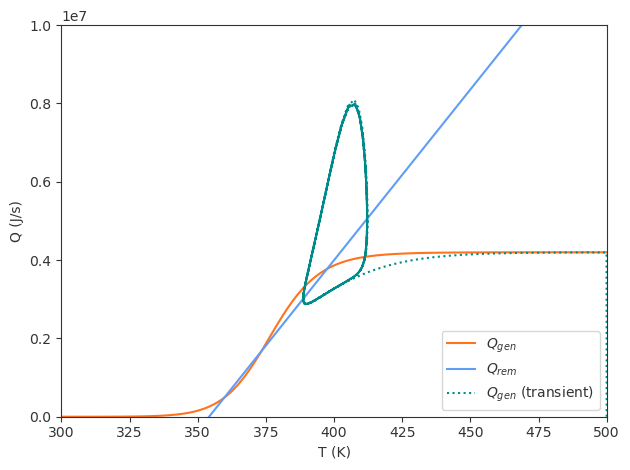

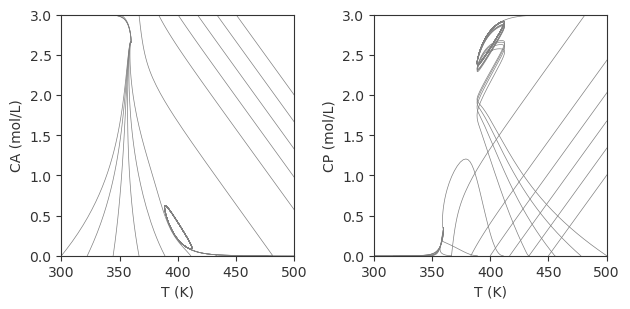

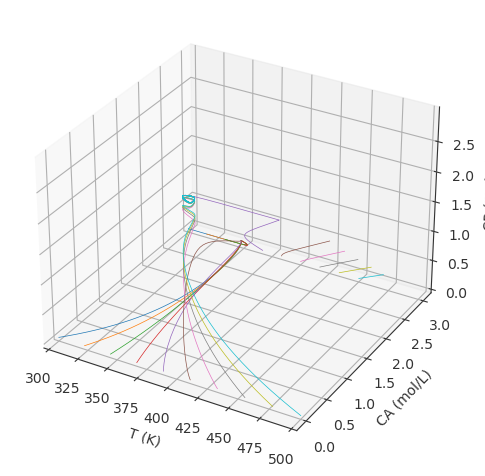

In [10]:
t_max = 5000
dt = 1.0

n = 10
T_lim = 300, 500
initials = np.array([[T0, CA0]]).repeat(n, axis=0)
initials = np.append(initials, np.zeros((n, 2)), axis=0)
initials[:n, 0] = np.linspace(T_lim[0], 450, n)
initials[n:, 0] = np.linspace(T_lim[0], 500, n)

paths = []
Q_gen_list = []

for val in initials:
    t = np.zeros(1)
    T = np.array([val[0]])
    CA = np.array([val[1]])
    CP = np.array([0.])
    Q_gen_transient = Q_gen(CA[-1], T[-1])

    while t[-1] < t_max:
        y0 = np.array([CA[-1], CP[-1], T[-1]])
        y, dt, dt_new = adaptive_RK(dydt, y0, dt=dt, tol=1e-8)
        CA_new, CP_new, T_new = y

        t = np.append(t, t[-1] + dt)
        CA = np.append(CA, CA_new)
        CP = np.append(CP, CP_new)
        T = np.append(T, T_new)
        Q_gen_transient = np.append(Q_gen_transient, Q_gen(CA_new, T_new))

        if T_new > T_lim[1]: break
        print(f'\rt = {t[-1]:.2f} s, CA = {CA[-1]:.3f} kmol/m3, CP = {CP[-1]:.3f} kmol/m3, '
              f'T = {T[-1]:.2f} K, dt = {dt:.2e} s', end='')
        dt = dt_new

    xyz = np.concatenate((T, CA, CP)).reshape((3, -1))
    paths.append(xyz)
    Q_gen_list.append(Q_gen_transient)


"""plots"""
text_color = '#333333'
plt.rcParams.update({
    'text.color': text_color,
    'axes.labelcolor': text_color,
    'axes.edgecolor': text_color,
    'xtick.color': text_color,
    'ytick.color': text_color,
})

fig_QT = plt.figure(1, layout='tight')
fig_CT = plt.figure(2, figsize=(6.4, 3.2), layout='tight')
fig_phase3d = plt.figure(3, layout='tight')
ax_QT = fig_QT.add_subplot()
ax_CT1 = fig_CT.add_subplot(121)
ax_CT2 = fig_CT.add_subplot(122)
ax_phase3d = fig_phase3d.add_subplot(projection='3d')

Ts = np.linspace(*T_lim, 100)
CAs = lambda T: CA0 / (1 + k1(T) * VR / v)

ax_QT.plot(Ts, Q_gen(CAs(Ts), Ts), color='#FF731D', label='$Q_{gen}$')
ax_QT.plot(Ts, Q_rem(Ts), color='#5F9DF7', label='$Q_{rem}$')
ax_QT.plot(paths[-1][0], Q_gen_list[-1], ':', color='darkcyan', label='$Q_{gen}$ (transient)')
ax_QT.legend(loc='lower right')
ax_QT.set(xlabel='T (K)', ylabel='Q (J/s)',
          xlim=T_lim, ylim=(0, 1e7))
ax_QT.ticklabel_format(axis='y', scilimits=[-3, 3])

for xyz in paths:
    # C_total = xyz[1:].sum(axis=0)
    T, CA, CP = xyz
    ax_CT1.plot(T, CA, linewidth=0.5, color='gray')
    ax_CT2.plot(T, CP, linewidth=0.5, color='gray')

    xyz = np.concatenate((T, xyz[1], xyz[2])).reshape((3, -1))
    ax_phase3d.plot(*xyz, linewidth=0.5)
ax_CT1.set(xlabel='T (K)', ylabel='CA (mol/L)', xlim=T_lim, ylim=(0, CA0))
ax_CT2.set(xlabel='T (K)', ylabel='CP (mol/L)', xlim=T_lim, ylim=(0, CA0))
ax_phase3d.set(xlabel='T (K)', ylabel='CA (mol/L)', zlabel='CP (mol/L)',
               xlim=T_lim)
plt.show()
# %matplotlib